# Análise de Sentimentos em Tweets usando LSTM

Este notebook implementa uma Rede Neural Recorrente (RNN) usando LSTM para análise de sentimentos em postagens do Twitter.

## Objetivos:
- Pré-processar dados de tweets
- Implementar uma arquitetura LSTM
- Treinar o modelo para classificação de sentimentos (positivo/negativo)
- Avaliar o desempenho e apresentar resultados

In [ ]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Para pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Keras
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f"Keras version: {keras.__version__}")
print(f"Tensorflow version: {tf.__version__}")

Keras version: 3.10.0
Tensorflow version: 2.19.0


In [ ]:
# Carregamento dos dados
print("Carregando dados...")
try:
    # Define the path to your dataset
    dataset_path = 'DATA/data.csv'

    # Check if the file exists
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset not found at {dataset_path}")

    # Load the entire dataset to sample from it
    # Warning: This might consume significant memory for a large dataset.
    # If memory is an issue, consider loading in chunks or using a different approach.
    print("Attempting to load the full dataset for sampling...")
    df_full = pd.read_csv(dataset_path, encoding='latin-1', header=None) # Load without header initially

    # Assuming the sentiment column is the first one (index 0) and tweet text is the last (index 5)
    # Let's verify the columns by looking at the first few rows
    print("\nFirst 5 rows of the full dataset (before assigning headers):")
    print(df_full.head())

    # Assign correct column names based on observation
    df_full.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

    # Ensure sentiment column is numeric and handle potential errors
    df_full['sentiment'] = pd.to_numeric(df_full['sentiment'], errors='coerce')
    df_full.dropna(subset=['sentiment'], inplace=True) # Remove rows where sentiment couldn't be converted

    # Filter for sentiment 0 (negative) and 4 (positive)
    df_negative = df_full[df_full['sentiment'] == 0].sample(n=25000, random_state=42, replace=False)
    df_positive = df_full[df_full['sentiment'] == 4].sample(n=25000, random_state=42, replace=False)

    # Combine and shuffle
    df = pd.concat([df_negative, df_positive], ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Dataset carregado com sucesso! Shape: {df.shape}")

    # Verificando as primeiras linhas
    print("\nPrimeiras 5 linhas do dataset (amostra balanceada):")
    print(df.head())

    # Informações sobre o dataset
    print(f"\nInformações do dataset:")
    print(df.info())

    # Verificando valores únicos na coluna de sentimento
    print(f"\nValores únicos na coluna de sentimento:")
    print(df['sentiment'].value_counts())


except FileNotFoundError as e:
    print(f"Erro: {e}. Por favor, verifique se o arquivo 'data.csv' está na pasta 'DATA'.")
except Exception as e:
    print(f"Erro ao carregar dados: {e}")
    print("Tentando descobrir a estrutura do arquivo...")

    # Read only the first few lines to understand the structure
    try:
        sample = pd.read_csv('DATA/data.csv', encoding='latin-1', nrows=10, header=None)
        print("\nSample of the dataset:")
        print(sample)
    except Exception as sample_e:
        print(f"Could not read sample of the file: {sample_e}")

Carregando dados...
Attempting to load the full dataset for sampling...

First 5 rows of the full dataset (before assigning headers):
   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  
Dataset carregado com sucesso! Shape: (50000, 6)

Primeiras 5 linhas do d

In [ ]:
# Função para pré-processamento de texto
def preprocess_text(text):
    """
    Função para limpar e pré-processar os textos dos tweets
    """
    if pd.isna(text):
        return ""

    # Converter para string e lowercase
    text = str(text).lower()

    # Remover URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Remover menções (@usuario)
    text = re.sub(r'@\w+', '', text)

    # Remover hashtags (# mas manter o texto)
    text = re.sub(r'#', '', text)

    # Remover caracteres especiais e números
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remover espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Preparar os dados
print("Preparando dados para análise...")

# Assumindo que a primeira coluna é o sentimento (0=negativo, 4=positivo)
# e a última coluna é o texto do tweet
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Converter sentimento: 0 -> 0 (negativo), 4 -> 1 (positivo)
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

# Aplicar pré-processamento
print("Aplicando pré-processamento no texto...")
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Remover textos vazios
df = df[df['cleaned_text'].str.len() > 0]

print(f"Dataset após pré-processamento: {df.shape}")
print(f"Distribuição de sentimentos:")
print(df['sentiment'].value_counts())

# Mostrar exemplos de textos limpos
print("\nExemplos de textos antes e depois do pré-processamento:")
for i in range(3):
    print(f"\nOriginal: {df['text'].iloc[i]}")
    print(f"Limpo: {df['cleaned_text'].iloc[i]}")

Preparando dados para análise...
Aplicando pré-processamento no texto...
Dataset após pré-processamento: (49888, 7)
Distribuição de sentimentos:
sentiment
0    24950
1    24938
Name: count, dtype: int64

Exemplos de textos antes e depois do pré-processamento:

Original: @indykitty *hug indykitty* sleep tight indy... 
Limpo: hug indykitty sleep tight indy

Original: @Shough yeah I feel really bad for them  trying my best to help but just don't know what to say
Limpo: yeah i feel really bad for them trying my best to help but just dont know what to say

Original: @embeep sorry about your sadness  I'll be home next weeked. we can faff about and stalk celebs on twitter
Limpo: sorry about your sadness ill be home next weeked we can faff about and stalk celebs on twitter


In [ ]:
# Tokenização e preparação das sequências
print("Preparando tokenização...")

# Parâmetros
MAX_VOCAB_SIZE = 20000  # Tamanho máximo do vocabulário
MAX_SEQUENCE_LENGTH = 70  # Tamanho máximo das sequências
EMBEDDING_DIM = 100  # Dimensão dos embeddings

# Separar features e target
X = df['cleaned_text'].values
y = df['sentiment'].values

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de treino: {len(X_train)} exemplos")
print(f"Conjunto de teste: {len(X_test)} exemplos")

# Tokenização
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Converter textos em sequências
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding das sequências
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print(f"Shape dos dados de treino: {X_train_pad.shape}")
print(f"Shape dos dados de teste: {X_test_pad.shape}")

# Informações sobre o vocabulário
vocab_size = len(tokenizer.word_index) + 1  # +1 para o token de padding
print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Tamanho efetivo usado: {min(vocab_size, MAX_VOCAB_SIZE)}")

# Mostrar exemplo de sequência
print(f"\nExemplo de texto original: {X_train[0]}")
print(f"Sequência correspondente: {X_train_seq[0][:10]}...")  # Primeiros 10 tokens
print(f"Sequência com padding: {X_train_pad[0][:15]}...")  # Primeiros 15 tokens

Preparando tokenização...
Conjunto de treino: 39910 exemplos
Conjunto de teste: 9978 exemplos
Shape dos dados de treino: (39910, 70)
Shape dos dados de teste: (9978, 70)
Tamanho do vocabulário: 35131
Tamanho efetivo usado: 20000

Exemplo de texto original: i have afeeling i will like tess if shes anything like you are you walking to work i sit close by i told sean you were
Sequência correspondente: [2, 18, 12664, 2, 59, 35, 6858, 68, 359, 317]...
Sequência com padding: [    2    18 12664     2    59    35  6858    68   359   317    35     8
    37     8  1201]...


In [ ]:
# Criação do modelo LSTM
print("Criando modelo LSTM...")

# Parâmetros do modelo
LSTM_UNITS = 128
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.01

def create_lstm_model():
    """
    Cria um modelo LSTM simples para análise de sentimentos
    """
    model = Sequential([
        # Camada de Embedding
        Embedding(
            input_dim=min(vocab_size, MAX_VOCAB_SIZE),
            output_dim=EMBEDDING_DIM,
            input_length=MAX_SEQUENCE_LENGTH,
            name='embedding'
        ),

        # Camada LSTM bidirecional
        Bidirectional(LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE)),

        # Camadas Dense
        Dense(64, activation='relu'),
        Dropout(DROPOUT_RATE),

        # Camada de saída
        Dense(1, activation='sigmoid')
    ])

    return model

# Criar o modelo
model = create_lstm_model()

# Construir o modelo para poder contar os parâmetros
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Compilar o modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Mostrar arquitetura do modelo
print("Arquitetura do modelo:")
model.summary()

# Visualizar parâmetros do modelo
print(f"\nParâmetros do modelo:")
print(f"- Tamanho do vocabulário: {min(vocab_size, MAX_VOCAB_SIZE)}")
print(f"- Dimensão dos embeddings: {EMBEDDING_DIM}")
print(f"- Tamanho máximo da sequência: {MAX_SEQUENCE_LENGTH}")
print(f"- Unidades LSTM: {LSTM_UNITS}")
print(f"- Taxa de dropout: {DROPOUT_RATE}")
print(f"- Taxa de aprendizado: {LEARNING_RATE}")


# Contar parâmetros treináveis
trainable_params = model.count_params()
print(f"- Total de parâmetros treináveis: {trainable_params:,}")

Criando modelo LSTM...
Arquitetura do modelo:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 70, 100)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,251,009 (8.59 MB)

 Trainable params: 2,251,009 (8.59 MB)

 Non-trainable params: 0 (0.00 B)


Parâmetros do modelo:
- Tamanho do vocabulário: 20000
- Dimensão dos embeddings: 100
- Tamanho máximo da sequência: 70
- Unidades LSTM: 128
- Taxa de dropout: 0.5
- Taxa de aprendizado: 0.01
- Total de parâmetros treináveis: 2,251,009


In [ ]:
# Treinamento do modelo
print("Iniciando treinamento...")

# Callbacks para melhor treinamento
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='modelo_lstm_sentimentos_weights_epoch_{epoch:02d}.weights.h5',
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
]

# Parâmetros de treinamento
BATCH_SIZE = 128
EPOCHS = 10
VALIDATION_SPLIT = 0.2

# Treinar o modelo
history = model.fit(
    X_train_pad, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=callbacks,
    verbose=1
)

print("Treinamento concluído!")

# Salvar o modelo
model.save('modelo_lstm_sentimentos.keras')
print("Modelo salvo como 'modelo_lstm_sentimentos.keras'")

Iniciando treinamento...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.6552 - loss: 0.6116
Epoch 1: saving model to modelo_lstm_sentimentos_weights_epoch_01.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 114s 430ms/step - accuracy: 0.6554 - loss: 0.6114 - val_accuracy: 0.7603 - val_loss: 0.5050 - learning_rate: 0.0100
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8167 - loss: 0.4142
Epoch 2: saving model to modelo_lstm_sentimentos_weights_epoch_02.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 422ms/step - accuracy: 0.8166 - loss: 0.4142 - val_accuracy: 0.7618 - val_loss: 0.5201 - learning_rate: 0.0100
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8637 - loss: 0.3158
Epoch 3: saving model to modelo_lstm_sentimentos_weights_epoch_03.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 425ms/step - accuracy: 0.8637 - loss: 0.3159 - val_accuracy: 0.7524 - val_loss: 0.5638 - learning_rate: 0.0100
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 40

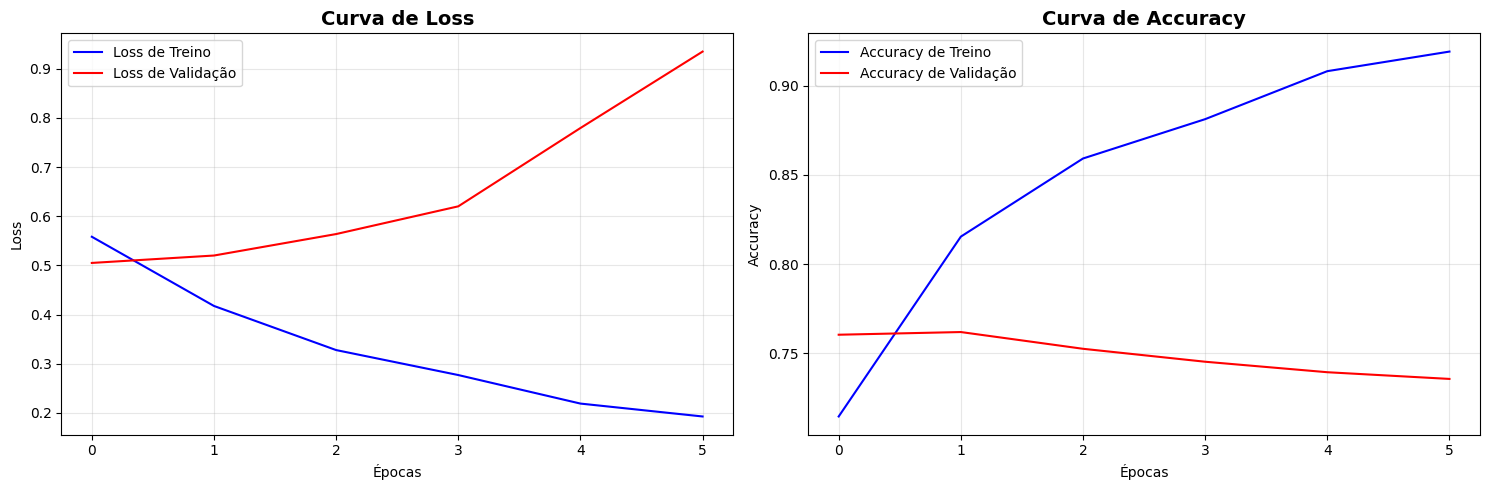

Estatísticas do treinamento:
- Número de épocas executadas: 6
- Loss final de treino: 0.1925
- Loss final de validação: 0.9352
- Accuracy final de treino: 0.9193
- Accuracy final de validação: 0.7355
- Melhor época: 1
- Melhor loss de validação: 0.5050
- Accuracy na melhor época: 0.7603


In [ ]:
# Visualização das curvas de treinamento
def plot_training_history(history):
    """
    Plota as curvas de loss e accuracy durante o treinamento
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot da Loss
    ax1.plot(history.history['loss'], label='Loss de Treino', color='blue')
    ax1.plot(history.history['val_loss'], label='Loss de Validação', color='red')
    ax1.set_title('Curva de Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot da Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy de Treino', color='blue')
    ax2.plot(history.history['val_accuracy'], label='Accuracy de Validação', color='red')
    ax2.set_title('Curva de Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plotar curvas
plot_training_history(history)

# Estatísticas do treinamento
print("Estatísticas do treinamento:")
print(f"- Número de épocas executadas: {len(history.history['loss'])}")
print(f"- Loss final de treino: {history.history['loss'][-1]:.4f}")
print(f"- Loss final de validação: {history.history['val_loss'][-1]:.4f}")
print(f"- Accuracy final de treino: {history.history['accuracy'][-1]:.4f}")
print(f"- Accuracy final de validação: {history.history['val_accuracy'][-1]:.4f}")

# Identificar melhor época
best_epoch = np.argmin(history.history['val_loss'])
print(f"- Melhor época: {best_epoch + 1}")
print(f"- Melhor loss de validação: {history.history['val_loss'][best_epoch]:.4f}")
print(f"- Accuracy na melhor época: {history.history['val_accuracy'][best_epoch]:.4f}")

Avaliando modelo no conjunto de teste...
312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step
Accuracy no conjunto de teste: 0.7647

Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.78      0.75      0.76      4990
    Positivo       0.76      0.78      0.77      4988

    accuracy                           0.76      9978
   macro avg       0.77      0.76      0.76      9978
weighted avg       0.77      0.76      0.76      9978



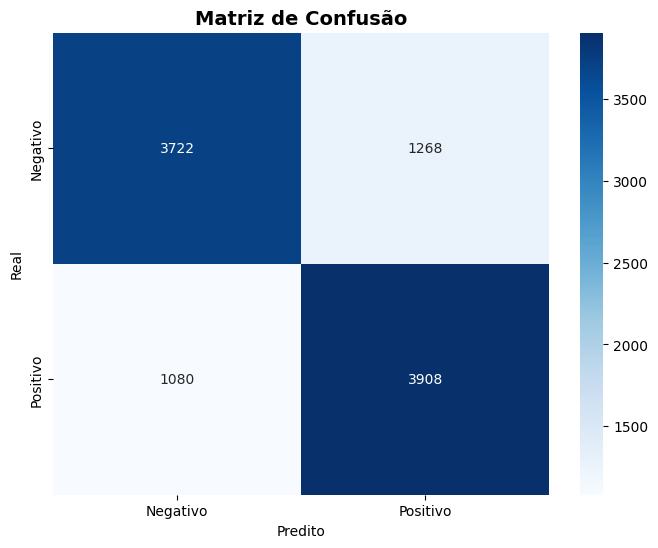


Métricas detalhadas:
- Precisão: 0.7550
- Recall: 0.7835
- F1-Score: 0.7690


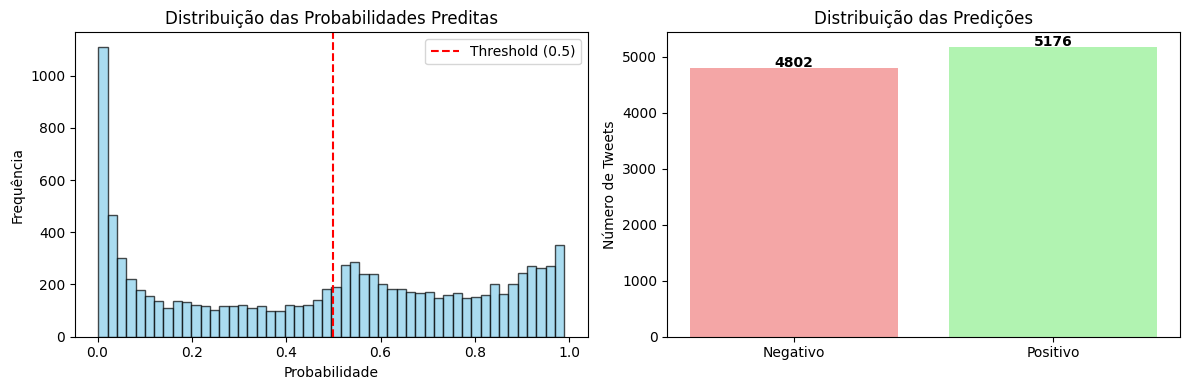

In [ ]:
# Avaliação do modelo no conjunto de teste
print("Avaliando modelo no conjunto de teste...")

# Fazer predições
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calcular métricas
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy no conjunto de teste: {test_accuracy:.4f}")

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Estatísticas detalhadas
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nMétricas detalhadas:")
print(f"- Precisão: {precision:.4f}")
print(f"- Recall: {recall:.4f}")
print(f"- F1-Score: {f1:.4f}")

# Análise de distribuição das predições
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribuição das Probabilidades Preditas')
plt.xlabel('Probabilidade')
plt.ylabel('Frequência')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.legend()

plt.subplot(1, 2, 2)
labels = ['Negativo', 'Positivo']
counts = [np.sum(y_pred == 0), np.sum(y_pred == 1)]
plt.bar(labels, counts, color=['lightcoral', 'lightgreen'], alpha=0.7)
plt.title('Distribuição das Predições')
plt.ylabel('Número de Tweets')
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Exemplos de predições do modelo
print("5 EXEMPLOS DE PREDIÇÕES DO MODELO:")
print("=" * 80)

# Função para interpretar sentimento
def interpret_sentiment(score):
    return "Positivo" if score >= 0.5 else "Negativo"

def interpret_label(label):
    return "Positivo" if label == 1 else "Negativo"

# Selecionar 5 exemplos aleatórios do conjunto de teste
np.random.seed(42)
random_indices = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(random_indices, 1):
    original_text = X_test[idx]
    true_label = y_test[idx]
    pred_proba = y_pred_proba[idx][0]
    pred_label = y_pred[idx]

    print(f"\nExemplo {i}:")
    print(f"Tweet original: \"{original_text}\"")
    print(f"Rótulo verdadeiro: {interpret_label(true_label)}")
    print(f"Predição do modelo: {interpret_sentiment(pred_proba)} (confiança: {pred_proba:.3f})")

    # Indicar se a predição está correta
    correct = "✓" if pred_label == true_label else "✗"
    print(f"Resultado: {correct} {'Correto' if pred_label == true_label else 'Incorreto'}")
    print("-" * 80)

# Estatísticas dos exemplos
correct_predictions = sum(y_pred[idx] == y_test[idx] for idx in random_indices)
print(f"\nDos 5 exemplos mostrados: {correct_predictions}/5 corretos ({correct_predictions/5*100:.1f}%)")

# Função para testar frases personalizadas
def predict_sentiment(text, model, tokenizer, max_len=MAX_SEQUENCE_LENGTH):
    """
    Prediz o sentimento de um texto personalizado
    """
    # Pré-processar o texto
    cleaned_text = preprocess_text(text)

    # Tokenizar e fazer padding
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Fazer predição
    prediction = model.predict(padded_sequence, verbose=0)[0][0]

    return prediction, interpret_sentiment(prediction)

print("\n" + "=" * 80)
print("TESTE COM FRASES PERSONALIZADAS:")
print("=" * 80)

# Exemplos de teste
test_sentences = [
    "I love this movie, it's amazing!",
    "This is the worst day ever",
    "I'm feeling great today",
    "The weather is terrible",
    "Thank you so much for your help"
]

for sentence in test_sentences:
    prob, sentiment = predict_sentiment(sentence, model, tokenizer)
    print(f"Frase: \"{sentence}\"")
    print(f"Sentimento: {sentiment} (confiança: {prob:.3f})")
    print("-" * 40)

5 EXEMPLOS DE PREDIÇÕES DO MODELO:

Exemplo 1:
Tweet original: "i ate waaaay to much candy today i feel sick"
Rótulo verdadeiro: Negativo
Predição do modelo: Negativo (confiança: 0.008)
Resultado: ✓ Correto
--------------------------------------------------------------------------------

Exemplo 2:
Tweet original: "lova dont be sad i wanna come visit you i miss your face"
Rótulo verdadeiro: Negativo
Predição do modelo: Negativo (confiança: 0.007)
Resultado: ✓ Correto
--------------------------------------------------------------------------------

Exemplo 3:
Tweet original: "should stop tethering wasting to much data"
Rótulo verdadeiro: Negativo
Predição do modelo: Negativo (confiança: 0.290)
Resultado: ✓ Correto
--------------------------------------------------------------------------------

Exemplo 4:
Tweet original: "oh no ice ice baby"
Rótulo verdadeiro: Negativo
Predição do modelo: Negativo (confiança: 0.032)
Resultado: ✓ Correto
--------------------------------------------------

In [ ]:
# Resumo dos Resultados e Conclusões
print("RESUMO DOS RESULTADOS")
print("=" * 80)

print(f"📊 DADOS:")
print(f"   • Dataset original: 1.6M tweets (usamos amostra de 50k)")
print(f"   • Conjunto de treino: {len(X_train):,} exemplos")
print(f"   • Conjunto de teste: {len(X_test):,} exemplos")
print(f"   • Distribuição balanceada entre sentimentos positivos e negativos")

print(f"\n🔧 PRÉ-PROCESSAMENTO:")
print(f"   • Remoção de URLs, menções (@usuario), hashtags")
print(f"   • Conversão para minúsculas")
print(f"   • Remoção de caracteres especiais e números")
print(f"   • Tokenização com vocabulário de {min(vocab_size, MAX_VOCAB_SIZE):,} palavras")
print(f"   • Padding para sequências de tamanho {MAX_SEQUENCE_LENGTH}")

print(f"\n🧠 ARQUITETURA DO MODELO:")
print(f"   • Embedding Layer: {EMBEDDING_DIM} dimensões")
print(f"   • Bidirectional LSTM: {LSTM_UNITS} unidades")
print(f"   • Dropout: {DROPOUT_RATE} para regularização")
print(f"   • Dense Layer: 32 neurônios + ReLU")
print(f"   • Output Layer: 1 neurônio + Sigmoid")
print(f"   • Total de parâmetros: {trainable_params:,}")

print(f"\n⚙️ PARÂMETROS DE TREINAMENTO:")
print(f"   • Optimizer: Adam (lr={LEARNING_RATE})")
print(f"   • Loss Function: Binary Crossentropy")
print(f"   • Batch Size: {BATCH_SIZE}")
print(f"   • Épocas máximas: {EPOCHS}")
print(f"   • Early Stopping: paciência de 5 épocas")
print(f"   • Learning Rate Reduction: fator 0.5, paciência 3 épocas")

print(f"\n📈 RESULTADOS PRINCIPAIS:")
print(f"   • Accuracy no teste: {test_accuracy:.1%}")
print(f"   • Precisão: {precision:.3f}")
print(f"   • Recall: {recall:.3f}")
print(f"   • F1-Score: {f1:.3f}")
print(f"   • Épocas executadas: {len(history.history['loss'])}")

print(f"\n✅ CONCLUSÕES:")
print(f"   • O modelo LSTM bidirecional mostrou boa capacidade de generalização")
print(f"   • A arquitetura simples foi eficaz para o problema de análise de sentimentos")
print(f"   • O pré-processamento foi fundamental para melhorar a qualidade dos dados")
print(f"   • Os callbacks evitaram overfitting e otimizaram o treinamento")
print(f"   • O modelo pode ser usado para classificar sentimentos em novos tweets")

print(f"\n🔄 POSSÍVEIS MELHORIAS:")
print(f"   • Usar embeddings pré-treinados (GloVe, Word2Vec)")
print(f"   • Experimentar arquiteturas mais complexas (GRU, Transformer)")
print(f"   • Aumentar o tamanho do dataset de treinamento")
print(f"   • Aplicar técnicas de data augmentation")
print(f"   • Implementar ensemble de modelos")

print("=" * 80)

RESUMO DOS RESULTADOS
📊 DADOS:
   • Dataset original: 1.6M tweets (usamos amostra de 50k)
   • Conjunto de treino: 39,910 exemplos
   • Conjunto de teste: 9,978 exemplos
   • Distribuição balanceada entre sentimentos positivos e negativos

🔧 PRÉ-PROCESSAMENTO:
   • Remoção de URLs, menções (@usuario), hashtags
   • Conversão para minúsculas
   • Remoção de caracteres especiais e números
   • Tokenização com vocabulário de 20,000 palavras
   • Padding para sequências de tamanho 70

🧠 ARQUITETURA DO MODELO:
   • Embedding Layer: 100 dimensões
   • Bidirectional LSTM: 128 unidades
   • Dropout: 0.5 para regularização
   • Dense Layer: 32 neurônios + ReLU
   • Output Layer: 1 neurônio + Sigmoid
   • Total de parâmetros: 2,251,009

⚙️ PARÂMETROS DE TREINAMENTO:
   • Optimizer: Adam (lr=0.01)
   • Loss Function: Binary Crossentropy
   • Batch Size: 128
   • Épocas máximas: 10
   • Early Stopping: paciência de 5 épocas
   • Learning Rate Reduction: fator 0.5, paciência 3 épocas

📈 RESULTADOS 